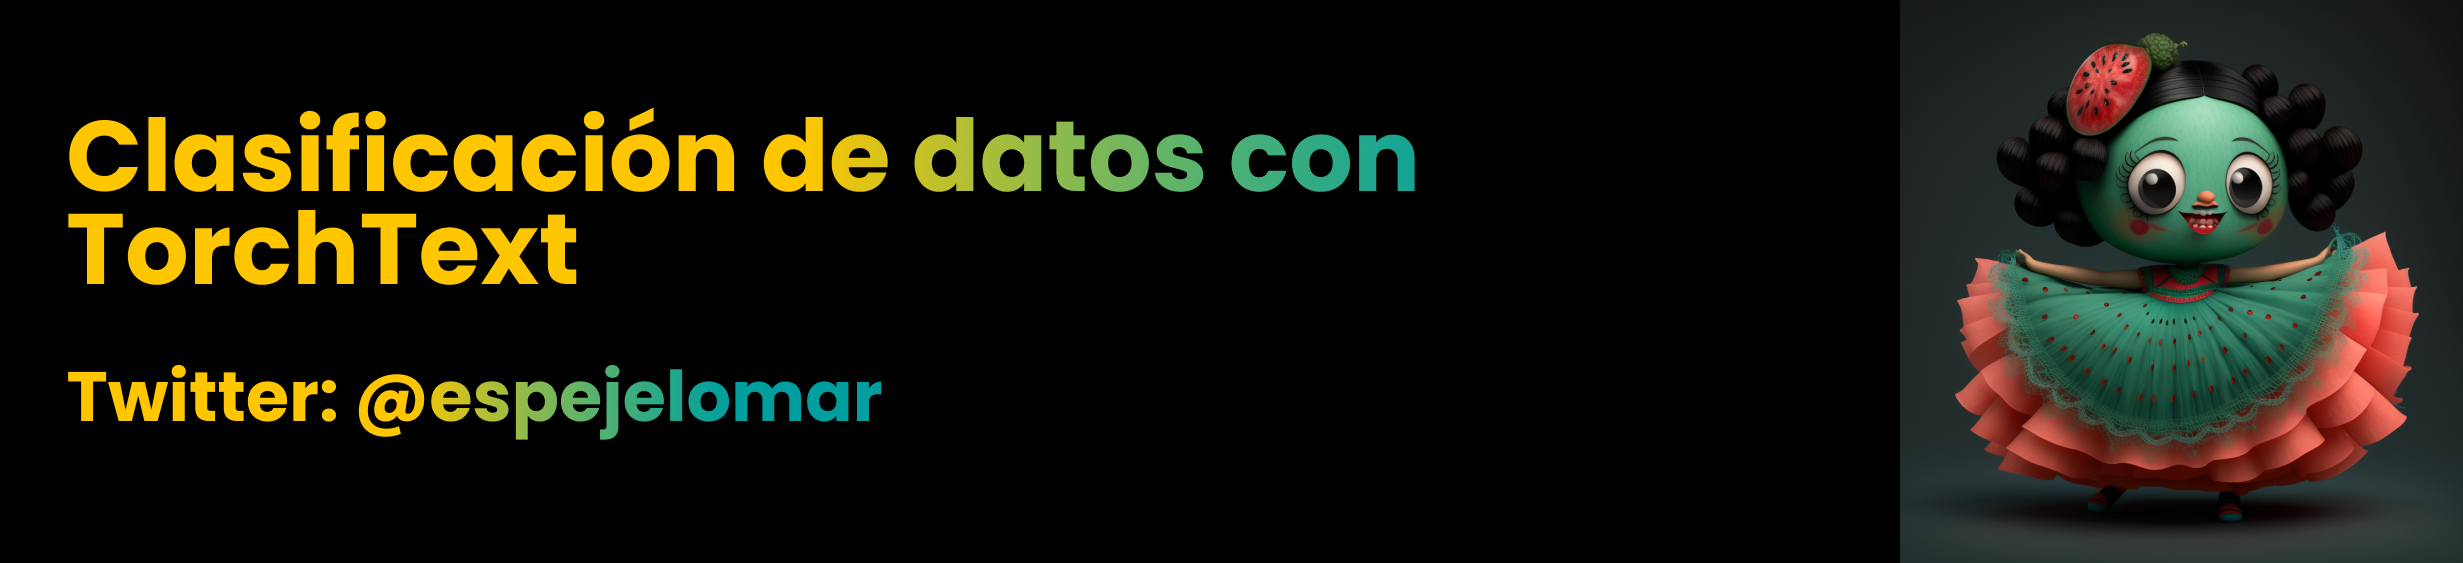

El Proyecto PyTorch contiene librerías para diferentes tipos de datos y fines.

* `torchaudio`
* `torchvision`
* `TorchElastic`
* `TorchServe`

Vamos a utilizar `torchtext` para clasificación de texto. El paquete `torchtext` consta de utilidades de procesamiento de datos y conjuntos de datos populares para lenguaje natural.

Sin embargo, no dudes en probar otras de las librerías disponibles en PyTorch. ¡`torchvision` es particularmente utilizado por aplicaciones que trabajan con imágenes!

## 1. Importando librerías y dataset

In [20]:
%%capture
!pip install portalocker>=2.0.0
# !pip install torchtext --upgrade

In [21]:
import torch
import torchtext
# from torchtext.datasets import DBpedia
from dbpedia import DBpedia
import os
 
# Comprobar la versión
torchtext.__version__

'0.18.0+cpu'

## 2. Procesando el dataset y creando un vocabulario

Importa las bibliotecas `torch` y `torchtext`. Utiliza `torchtext` para cargar el conjunto de datos DBpedia. 

Luego, utiliza la función `iter` para crear un objeto de iteración para el conjunto de datos de entrenamiento. Finalmente, el código imprime la versión de la biblioteca `torchtext` utilizada.

In [22]:
train_dp = DBpedia(root=os.path.expanduser("~/.torchtext/cache"), split="train")
train_iter = iter(DBpedia(split="train"))

In [23]:
next(train_iter)

(1,
 'E. D. Abbott Ltd  Abbott of Farnham E D Abbott Limited was a British coachbuilding business based in Farnham Surrey trading under that name from 1929. A major part of their output was under sub-contract to motor vehicle manufacturers. Their business closed in 1972.')

Construiremos un vocabulario con el conjunto de datos implementando la función incorporada `build_vocab_from_iterator`que acepta el iterador que produce una lista o un iterador de tokens.

Usamos `torchtext` para construir un vocabulario a partir de un conjunto de datos del DBpedia en inglés. 

En primer lugar, importa la función `get_tokenizer` de la biblioteca `torchtext` para obtener un tokenizador predefinido para el idioma inglés. Luego, define un iterador de datos para el conjunto de datos de entrenamiento de DBpedia.

A continuación, se define una función `yield_tokens` que utiliza el tokenizador para dividir el texto en tokens y devolverlos uno a uno. Esta función se utiliza como entrada para la función `build_vocab_from_iterator`, que construye un vocabulario a partir de los tokens devueltos por la función `yield_tokens`. La función `build_vocab_from_iterator` también toma una lista de tokens especiales, que se utilizarán para representar palabras fuera del vocabulario.

Finalmente, se establece el índice predeterminado del vocabulario en el token "<unk>", que se utiliza para representar palabras que no están presentes en el vocabulario. En resumen, este fragmento de código construye un vocabulario a partir de un conjunto de datos de entrenamiento y lo prepara para su uso en modelos de aprendizaje automático que utilizan PyTorch.



In [24]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

tokenizador = get_tokenizer("basic_english")
train_iter = DBpedia(split="train")

def yield_tokens(data_iter):
    for _, text in data_iter:
        yield tokenizador(text)
        
vocab = build_vocab_from_iterator(yield_tokens(train_iter), specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])
        

Nuestro vocabulario transforma la lista de tokens en números enteros.

In [25]:
vocab(tokenizador("Hello how are you? I am a platzi student"))

[7296, 1506, 47, 578, 2323, 187, 2409, 5, 0, 1078]

Definimos dos funciones lambda, `text_pipeline` y `label_pipeline`, que se utilizan para procesar los datos de entrada en un formato que se puede utilizar para entrenar y evaluar modelos.

La primera función, `text_pipeline`, toma una cadena de texto como entrada y la procesa utilizando el tokenizador y el vocabulario que definimos. Recuerda que el tokenizador divide el texto en tokens (palabras o subpalabras), mientras que el vocabulario mapea cada token a un índice entero único. La función devuelve una lista de índices enteros que representan los tokens en el texto.

La segunda función, `label_pipeline`, toma una etiqueta como entrada y la convierte en un número entero. En este caso, la etiqueta se resta en `1` para ajustarla a un rango de índice de `0` a `n-1`, donde `n` es el número de clases en el problema.


In [26]:
texto_pipeline = lambda x: vocab(tokenizador(x))
label_pipeline = lambda x: int(x) - 1

In [27]:
texto_pipeline("Hello I am Alejandro")

[7296, 187, 2409, 7026]

In [28]:
label_pipeline("1")

0

Cargamos los datos de entrenamiento desde el dataset `DBpedia` utilizando PyTorch `DataLoader`. El código también define una función de agrupación personalizada llamada `collate_batch` que se utiliza para procesar los datos de entrada y convertirlos en un formato que se puede utilizar para entrenar modelos de machine learning.

Primero, se define el dispositivo donde haremos el procesamiento en función de la disponibilidad de la GPU. Luego, se define la función `collate_batch`, que toma un lote de datos de entrada y los procesa. La función separa las etiquetas y el texto en dos listas diferentes y procesa el texto utilizando las funciones de tokenización y etiquetado definidas anteriormente.

Una vez que los datos de entrada se han procesado, la función devuelve una tupla que contiene las etiquetas, el texto procesado y los desplazamientos, que se utilizan para realizar un seguimiento de la ubicación de cada ejemplo en el lote.

Finalmente, se cargan los datos de entrenamiento utilizando `DataLoader`, que divide el conjunto de datos en lotes y aplica la función de agrupación personalizada a cada lote para procesar los datos de entrada en un formato utilizable.

In [29]:
torch.cuda.is_available()

True

In [38]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

def collate_batch(batch):
    label_list = []
    text_list = []
    offsets = [0]
    
    for (_label, _text) in batch:
        label_list.append(label_pipeline(_label))
        processed_text = torch.tensor(texto_pipeline(_text), dtype=torch.int64)
        text_list.append(processed_text)
        offsets.append(processed_text.size(0))
        
    label_list = torch.tensor(label_list, dtype=torch.int64)
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    text_list = torch.cat(text_list)
    return label_list.to(device) , text_list.to(device) , offsets.to(device)
    

In [39]:
from torch.utils.data import DataLoader
train_iter = DBpedia(split="train")
dataloader = DataLoader(train_iter, batch_size=8, shuffle=False, collate_fn=collate_batch)

## 3. Creación de modelo de clasificación y sus capas

Definimos una clase que hereda `nn.Module` y que representa un modelo de clasificación de texto utilizando las capas de `EmbeddingBag` y `Linear`. El modelo toma como entrada el tamaño del vocabulario, la dimensión del embedding y el número de clases. Luego define la estructura del modelo utilizando las capas mencionadas anteriormente.

La función `forward` del modelo toma como entrada el texto y los desplazamientos correspondientes (offsets), que se utilizan para descomponer el texto en lotes (batches). La función `EmbeddingBag` se utiliza para transformar el texto en una representación de embedding. La capa `Lineal` se utiliza para realizar la clasificación de texto.








In [40]:
from torch import nn
import torch.nn.functional as F

class ModeloClasificacionTexto(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_class):
        
        super(ModeloClasificacionTexto, self).__init__()
        
        # Capa de incrustación (embedding)
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim)
        
        # Capa de normalización por lotes (batch normalization)
        self.bn1 = nn.BatchNorm1d(embed_dim)
        
        # Capa completamente conectada (fully connected)
        self.fc = nn.Linear(embed_dim, num_class)
        
    def forward(self, text, offsets):
        
        # Incrustar el texto (embed the text)
        embedded = self.embedding(text, offsets)
        
        # Aplicar la normalización por lotes (apply batch normalization)
        embedded_norm = self.bn1(embedded)
            
        # Aplicar la función de activación ReLU (apply the ReLU activation function)
        embedded_activated = F.relu(embedded_norm)
            
        # Devolver las probabilidades de clase (output the class probabilities)
        return self.fc(embedded_activated)
        


Construimos un modelo con una dimensión de embedding de 100.

In [41]:
train_iter = DBpedia(split="train")
num_class = len(set([label for (label, text) in train_iter]))
vocab_size = len(vocab)
embedding_size = 100

modelo = ModeloClasificacionTexto(vocab_size=vocab_size, embed_dim=embedding_size, num_class=num_class).to(device)

In [42]:
vocab_size

802998

In [44]:
# arquitectura
print(modelo)

# Número de parámetros entrenables en nuestro modelo
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"El modelo tiene {count_parameters(modelo):,} parámetros entrenables")

ModeloClasificacionTexto(
  (embedding): EmbeddingBag(802998, 100, mode='mean')
  (bn1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=100, out_features=14, bias=True)
)
El modelo tiene 80,301,414 parámetros entrenables


## 4. Funciones para entrenamiento y evaluación del modelo

Ahora, definimos las funciones para entrenar el modelo y evaluar los resultados.

Utilizamos `torch.nn.utils.clip_grad_norm_` para limitar el valor máximo de la norma del gradiente durante el entrenamiento de una red neuronal. En otras palabras, se asegura de que los gradientes no sean demasiado grandes y, por lo tanto, evita que la red neuronal se vuelva inestable durante el entrenamiento.

El primer argumento, `modelo.parameters()`, se refiere a los parámetros del modelo que se están entrenando. El segundo argumento, "0.1", es el valor máximo permitido para la norma del gradiente.

In [49]:

def entrena(dataloader):
    
    # Colocar el modelo en formato de entrenamiento
    modelo.train()

    # Inicializa accuracy, count y loss para cada epoch
    epoch_acc = 0
    epoch_loss = 0
    total_count = 0
    
    for idx, (label, text, offsets) in enumerate(dataloader):
        
        # reestablece los gradientes después de cada batch
        optimizer.zero_grad()
        
        # Obten predicciones del modelo
        prediccion = modelo(text, offsets)

        # Obten la pérdida
        loss = criterio(prediccion, label)
                
        # backpropage la pérdida y calcular los gradientes
        loss.backward()
        
        # Obten la accuracy
        acc = (prediccion.argmax(1) == label).sum()
        
        # Evita que los gradientes sean demasiado grandes 
        torch.nn.utils.clip_grad_norm_(modelo.parameters(), 0.1)

        # Actualiza los pesos
        optimizer.step()

        # Llevamos el conteo de la pérdida y el accuracy para esta epoch
        epoch_acc += acc.item()
        epoch_loss += loss.item()
        total_count += label.size(0)
        
        if idx % 500 == 0 and idx > 0:
            print(f"epoca {epoch} | {idx}/{len(dataloader)} batches | perdida {epoch_loss/total_count} | accuracy {epoch_acc/total_count}")

    return epoch_acc/total_count, epoch_loss/total_count

In [52]:

def evalua(dataloader):
    modelo.eval()
    epoch_acc = 0
    total_count = 0 
    epoch_loss = 0
    
    with torch.no_grad():
        for idx, (label, text, offsets) in enumerate(dataloader):
            # Obtenemos la la etiqueta predecida
            prediccion = modelo(text, offsets)

            # Obtenemos pérdida y accuracy
            loss = criterio(prediccion, label)
            acc = (prediccion.argmax(1) == label).sum()
            
            # Llevamos el conteo de la pérdida y el accuracy para esta epoch
            epoch_loss += loss.item()
            epoch_acc += acc.item()
            total_count += label.size(0)
            
    return epoch_acc/total_count , epoch_loss/total_count


## 5. Preparando el entrenamiento: split de datos, pérdida y optimización

Dividimos el conjunto de datos de entrenamiento en conjuntos de entrenamiento válidos con una proporción de división de 0.95 (entrenamiento) y 0.5 (válido) utilizando la función `torch.utils.data.dataset.random_split`

 

In [45]:
# Hiperparámetros

EPOCHS = 3 # epochs
TASA_APRENDIZAJE = 0.2  # tasa de aprendizaje
BATCH_TAMANO = 64 # tamaño de los batches

Explora las otras funciones de pérdida disponibles en PyTorch. Puedes encontrarlas todas aquí: https://pytorch.org/docs/stable/nn.html#loss-functions.

La función de pérdida es la que mide qué tan buenas son las predicciones de nuestro modelo en comparación con las etiquetas reales. PyTorch ofrece una amplia gama de funciones de pérdida que podemos utilizar para entrenar nuestros modelos en diferentes tipos de problemas, como regresión, clasificación y modelado de secuencia a secuencia.

Al profundizar en estas otras funciones de pérdida, podemos ampliar nuestro conocimiento de machine learning. Lo mismo aplica para los optimizadores. PyTorch proporciona una variedad de algoritmos de optimización: https://pytorch.org/docs/stable/optim.html#algorithms.

Dedica tiempo a explorar la documentación de PyTorch sobre funciones de pérdida y optimizadores. Experimenta con diferentes funciones en tus proyectos.

In [46]:
# Pérdida, optimizador
criterio = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(modelo.parameters(), lr=TASA_APRENDIZAJE)

Dividimos el conjunto de datos en tres partes: entrenamiento, validación y prueba. 

Primero, importamos la función `random_split` de la clase Dataset y la función `to_map_style_dataset` de `torchtext.data.functional`. Luego, cargamos el conjunto de datos `DBpedia` usando el método `DBpedia()`. A continuación, convertimos el conjunto de datos en un formato que pueda ser utilizado por el `DataLoader` de PyTorch utilizando la función `to_map_style_dataset`.

Luego, definimos la proporción de datos que utilizaremos para entrenar nuestro modelo (el 95%) y el porcentaje que utilizaremos para validar nuestro modelo (el 5%). Utilizamos la función `random_split` para dividir el conjunto de datos de entrenamiento en entrenamiento y validación.

Finalmente, creamos tres DataLoaders para cada parte del conjunto de datos: uno para el entrenamiento, uno para la validación y otro para la prueba. Utilizamos el argumento `batch_size` para definir el tamaño de los lotes de datos que se utilizarán en el entrenamiento y la prueba. El argumento `collate_fn` especifica cómo se deben unir las muestras de datos para formar un lote.


In [47]:
from torch.utils.data.dataset import random_split
from torchtext.data.functional import to_map_style_dataset

# Obten el trainset y testset
train_iter, test_iter = DBpedia()
train_dataset = to_map_style_dataset(train_iter)
test_dataset = to_map_style_dataset(test_iter)

# Entrenamos el modelo con el 95% de los datos del trainset
num_train =  int(len(train_dataset) * 0.95)

# Creamos un dataset de validación con el 5% del trainset
split_train_, split_valid_ = random_split(train_dataset, [num_train, len(train_dataset) - num_train])

# Creamos dataloaders listos para ingresar a nuestro modelo
train_dataloader = DataLoader(split_train_, batch_size=BATCH_TAMANO, shuffle=True, collate_fn=collate_batch)
valid_dataloader = DataLoader(split_valid_, batch_size=BATCH_TAMANO, shuffle=True, collate_fn=collate_batch)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_TAMANO, shuffle=True, collate_fn=collate_batch)


## 6. Entrenamiento y evaluación del modelo

Ahora vamos a entrenar y evaluar nuestro modelo. En primer lugar, se define la variable `mejor_loss_validacion` y se inicializa con un valor infinito positivo. Esta variable se utiliza para realizar un seguimiento de la mejor pérdida de validación durante el entrenamiento.

Luego, se realiza un `for` a través de las épocas. Dentro de cada época, se realiza el entrenamiento y la validación del modelo utilizando los conjuntos de datos de entrenamiento y validación respectivamente.

En otras palabras, si la pérdida de validación actual es menor que la mejor pérdida de validación anterior, se guarda el estado actual del modelo en el archivo `pesos_guardados.pt`.


In [53]:
# Obten la mejor pérdida 
major_loss_validation = float('inf')

# Entrenamos
for epoch in range(1, EPOCHS + 1):
    # Entrenamiento
    entrenamiento_acc , entrenamiento_loss = entrena(train_dataloader)
    
    # Validación
    validacion_acc, validacion_loss = evalua(valid_dataloader)

    # Guarda el mejor modelo
    if validacion_loss > major_loss_validation:
        best_valid_loss = validacion_loss
        torch.save(modelo.state_dict(), "mejores_guardados.pt")
    
    

epoca 1 | 500/8313 batches | perdida 0.023124116712701533 | accuracy 0.5879802894211577


KeyboardInterrupt: 

Evaluamos el modelo en el test dataset

In [ ]:


print(f'Accuracy del test dataset -> ')
print(f'Pérdida del test dataset -> ')

## 7. Inferencia

Probemos con un ejemplo aleatorio



In [ ]:
DBpedia_label = {1: 'Company',
                2: 'EducationalInstitution',
                3: 'Artist',
                4: 'Athlete',
                5: 'OfficeHolder',
                6: 'MeanOfTransportation',
                7: 'Building',
                8: 'NaturalPlace',
                9: 'Village',
                10: 'Animal',
                11: 'Plant',
                12: 'Album',
                13: 'Film',
                14: 'WrittenWork'}


ejemplo_1 = "Nithari is a village in the western part of the state of Uttar Pradesh India bordering on New Delhi. Nithari forms part of the New Okhla Industrial Development Authority's planned industrial city Noida falling in Sector 31. Nithari made international news headlines in December 2006 when the skeletons of a number of apparently murdered women and children were unearthed in the village."
ejemplo_2 = "Abbott of Farnham E D Abbott Limited was a British coachbuilding business based in Farnham Surrey trading under that name from 1929. A major part of their output was under sub-contract to motor vehicle manufacturers. Their business closed in 1972."



print(f"El ejemeplo 1 es una texto de categoría {}")
print(f"El ejemeplo 2 es una texto de categoría {}")

## 8. Almacenamiento y carga del modelo

El método `state_dict()` se utiliza para devolver el diccionario del estado del modelo. Este diccionario contiene todos los parámetros entrenables del modelo. Como pesos y sesgos en forma de tensores de PyTorch.

Es útil para una variedad de tareas, como guardar y cargar modelos o transferir los parámetros aprendidos de un modelo a otro. Permite manipular fácilmente el estado del modelo como un diccionario de parámetros con nombres, sin tener que acceder a ellos directamente.

Por ejemplo, si queremos guardar nuestro modelo en el disco de memoria, podemos utilizarlo para obtener un diccionario de los parámetros del modelo y luego guardar ese diccionario utilizando el módulo `pickle` de Python. Luego, cuando queramos cargar el modelo nuevamente, podemos utilizar el método `load_state_dict()` para cargar el diccionario guardado en una nueva instancia del modelo.

Subimos el modelo al Hub de Hugging Face para que otros miembros de la comunidad tengan acceso a él y también tengamos una copia en la nube.

Creamos el repositorio donde guardaremos nuestro modelo en el Hub de Hugging Face.

Subimos nuestro checkpoint.

Carguemos el checkpoint en un nuevo directorio llamado `weights`.

Ahora carguemos nuestro modelo

In [ ]:
ejemplo_2 = "Axolotls are members of the tiger salamander, or Ambystoma tigrinum, species complex, along with all other Mexican species of Ambystoma."




## Conclusión

En este módulo aprendimos a utilizar `torchtext` para entrenar un modelo de clasificación con datos reales. 

1. Empezamos por preprocesar los datos mediante la tokenización y la construcción de un vocabulario. 

2. Luego creamos un conjunto de datos de PyTorch y lo usamos para entrenar un modelo de clasificación con una arquitectura de red neuronal. 

3. Probamos el modelo con un conjunto de pruebas

4. Luego realizamos inferencia en nuevos datos. 

5. Finalmente, guardamos nuestro modelo entrenado para que pueda ser utilizado más adelante para otras tareas.